In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import requests
from io import StringIO
from bs4 import BeautifulSoup as BS
import json

In [2]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=1900-01-01&minlatitude=34.452&maxlatitude=37.44&minlongitude=-91.033&maxlongitude=-79.915&eventtype=earthquake'

In [3]:
r = requests.get(url)
data = r.json()

In [4]:
r.status_code

200

In [5]:
#data.keys()
#data['features'][0]

In [6]:
#data['features'][0]['properties']

In [7]:
contain = []
for d in data['features']:
    d['properties']['geometry'] = d['geometry']
    d['properties']['id'] = d['id']
    contain.append(d['properties'])

In [8]:
full = pd.DataFrame(contain)

In [9]:
full['TN'] = full['place'].str.contains('Tennessee')

In [10]:
#temp = temp[temp['TN']==True]
TN_eq = full.query('TN == True')

In [11]:
#TN_eq.info()

In [12]:
TN_eq.query('mag >= 2.5', inplace = True)

<ipython-input-12-72c8d77f3930>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TN_eq.query('mag >= 2.5', inplace = True)


In [13]:
#TN_eq.to_csv(r'..\Data\TN_eq.csv', index = False)

In [14]:
arc = pd.read_csv('../Data/arc.csv')

In [15]:
arc['time'] = pd.to_datetime(arc['time'])
arc.drop(columns = ['FID','FID_1'], inplace = True)

In [16]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   time        301 non-null    datetime64[ns, UTC]
 1   latitude    301 non-null    float64            
 2   longitude   301 non-null    float64            
 3   depth       301 non-null    float64            
 4   mag         301 non-null    float64            
 5   magType     301 non-null    object             
 6   nst         301 non-null    int64              
 7   gap         301 non-null    int64              
 8   dmin        301 non-null    float64            
 9   rms         301 non-null    float64            
 10  net         301 non-null    object             
 11  id          301 non-null    object             
 12  updated     301 non-null    object             
 13  place       301 non-null    object             
 14  horizontal  301 non-null    float64       

In [17]:
arc.set_index('time', inplace = True)

In [20]:
arc_agg = arc.mag.resample('10Y').count()
arc_agg = pd.DataFrame(arc_agg)

arc_agg = arc_agg.reset_index()
arc_agg['Year'] = arc_agg['time'].dt.year

In [21]:
print(arc_agg)

                        time  mag  Year
0  1913-12-31 00:00:00+00:00    1  1913
1  1923-12-31 00:00:00+00:00    1  1923
2  1933-12-31 00:00:00+00:00    1  1933
3  1943-12-31 00:00:00+00:00    0  1943
4  1953-12-31 00:00:00+00:00    0  1953
5  1963-12-31 00:00:00+00:00    4  1963
6  1973-12-31 00:00:00+00:00    3  1973
7  1983-12-31 00:00:00+00:00   36  1983
8  1993-12-31 00:00:00+00:00   37  1993
9  2003-12-31 00:00:00+00:00   44  2003
10 2013-12-31 00:00:00+00:00   70  2013
11 2023-12-31 00:00:00+00:00  104  2023


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

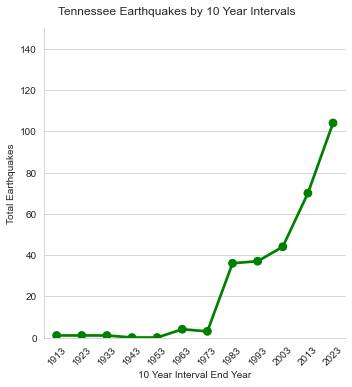

In [24]:
sns.set_style('whitegrid')

g = sns.catplot(x = 'Year', y = 'mag', 
            data = arc_agg, kind = 'point',
               color='g')

g.fig.suptitle('Tennessee Earthquakes by 10 Year Intervals', y=1.03)
g.set(xlabel = '10 Year Interval End Year')
g.set(ylabel = 'Total Earthquakes')

plt.ylim(0,150)
plt.xticks(rotation = 45)

In [28]:
arc = arc.reset_index()
arc['Hour'] = arc['time'].dt.hour

#Create day and night flags in the original dataframe

conditions = [(arc['Hour'] > 8) & (arc['Hour'] < 17), 
              (arc['Hour'] < 9), 
              (arc['Hour'] > 16)]
values = ['Day', 'Night', 'Night']

arc['TOD'] = np.select(conditions, values)

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Tennessee Earthquakes by Time of Day')]

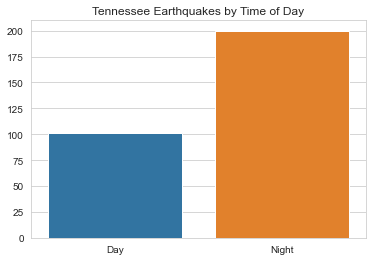

In [31]:
sns.set_style('whitegrid')

g = sns.countplot(x = 'TOD', 
            data = arc, order = ['Day', 'Night'])

g.set(xlabel = '', ylabel = '', title = 'Tennessee Earthquakes by Time of Day')

In [32]:
arc['TOD'].value_counts()

Night    200
Day      101
Name: TOD, dtype: int64